# Optimising the Optimisation
In this notebook, I look at how many inducing points, latent functions and LMC components I need to train the prediction model to beat a simple baseline.

I'll look at the ONeil dataset, in the LTO setting, using processed viability to predict the missing triplets. For comparison we use the simple Bliss non-interaction assumption.

Focussing on a single cell line, and a subset of the drugs, I can quickly get a sense of how many latent functions I need and how many inducing points they need.

In [1]:
import torch
import gpytorch
import pimogp
from pimogp.utils.utils import train_test_split_drugdata, prepdata
from pimogp.utils.runModel import runmodel

In [2]:
# Set some parameters
input_type = "processed"
targets = "fMean"
predtarget = "viability"
dataset = "ONeil"
seed = 122
setting = "LTO"
data, train, test, ids = train_test_split_drugdata(input_type=input_type,dataset=dataset,setting=setting,seed=seed)

In [3]:
# Just subset the data here to see if the number of inducing points were the issue
drugList = data["drugA"].unique()[0:12]

In [4]:
train = train[train['drugA'].isin(drugList)]
train = train[train['drugB'].isin(drugList)]
test = test[test['drugA'].isin(drugList)]
test = test[test['drugB'].isin(drugList)]

In [5]:
# Will focus on a single cell line, A2058
cell_line = "A2058"
train = train[train['cell_line'] == cell_line]
#train = train.iloc[0:5000]
test = test[test['cell_line'] == cell_line] 
#test = test.iloc[0:5000]
y_train, X_train, train_indices, train_noise, train_weights = prepdata(train, targets, predtarget)
y_test, X_test, test_indices, test_noise, test_weights = prepdata(test, targets, predtarget)

In [16]:
G = 1
num_latents = 1
num_inducing = 300
batch_size = 256
num_tasks = 1
num_epochs = 200
initial_lr = 0.01

In [17]:
from torch.utils.data import TensorDataset,  DataLoader
train_dataset = TensorDataset(X_train,y_train,train_noise,train_indices)
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)

# Define the permutation
permutation = torch.cat([torch.tensor([1]), torch.tensor([0]),
                             torch.linspace((2 + 50), 1 + (2 * 50), 50), torch.linspace(2, 1 + 50, 50)]).long()


In [18]:
from torch import Tensor
from typing import Literal
from pimogp.kernels.permutation_invariant_rbf import PermutationInvariantRBFKernel
from pimogp.variational.permutation_invariant_variational_strategy import PermutationInvariantVariationalStrategy
from botorch.models.utils.inducing_point_allocators import GreedyVarianceReduction

class TestModel(gpytorch.models.ApproximateGP):
    r"""
    DrugComboModelICM_NC is the model for drug combination prediction that utilizes drug covariates, but
    no cell line covariates

    It wraps a PermutationInvariantVariationalStrategy in an LMCVariationalStrategy for a multi-output GP.
    The parameters of the LMC are learned "free-form" as opposed to making use of cell line information

    :param permutation: A Tensor giving the permutation the function should be invariant to
    :param conc_dims: The dimensions of the data input that corresponds to the drug concentrations
    :param drug_covar_dims: The dimension of the data input that corresponds to the drug covariates
    :param num_tasks: The number of tasks / outputs / cell lines
    :param num_latents: The number of latent functions in the LMC
    :param num_inducing: The number of inducing points per latent
    :param sample_inducing_from: A Tensor to sample inducing points from, usually this would be the training inputs
    :param inducing_weights: A vector of weights used in sampling of the inducing points
    :param vardistr: The variational distribution to use, mf=MeanField (Default), "nat"=Natural, "chol"=Cholesky
    """

    def __init__(self, permutation: Tensor,
                 num_tasks: int,
                 num_latents: int,
                 num_inducing: int,
                 inducing_weights,
                 sample_inducing_from: Tensor,
                 ):

        
        covar_module = PermutationInvariantRBFKernel(permutation=permutation,permute_forward=True,
                                                     ard_num_dims=102)

        # Initialise the lengthscales
        lengthscales_init = sample_inducing_from.var(dim=0).sqrt().div(0.1)
        covar_module.lengthscale = lengthscales_init


        # Sample inducing points
        #p = inducing_weights.div(inducing_weights.sum())
        #idx = p.multinomial(num_samples=num_inducing * num_latents, replacement=False).reshape(num_latents,
        #                                                                                       num_inducing)
        #inducing_points = sample_inducing_from[idx]

        ind_allocator = GreedyVarianceReduction()
        inducing_points = torch.empty((0, num_inducing, sample_inducing_from.size(1)))
        for i in range(num_latents):
            sample = ind_allocator.allocate_inducing_points(sample_inducing_from, covar_module,
                                                num_inducing=num_inducing, input_batch_shape=torch.Size([]))
            inducing_points = torch.cat((inducing_points, sample.unsqueeze(0)), dim=0)
            matches = (sample_inducing_from.unsqueeze(1) == sample).all(dim=2)
            row_matches = matches.any(dim=1)
            sample_inducing_from = sample_inducing_from[~row_matches]
        #inducing_points = ind_allocator.allocate_inducing_points(sample_inducing_from.unsqueeze(0).repeat(num_latents,1,1),
        #                                                   covar_module_concentrations*covar_module_drugs,num_inducing=400,
        #                                                         input_batch_shape=torch.Size([num_latents]))

        # Now turn of the permutation forward
        #covar_module.permute_forward = False
        
        # Variational distribution
        variational_distribution = gpytorch.variational.NaturalVariationalDistribution(
            inducing_points.size(-2), batch_shape=torch.Size([num_latents])
            )

        # Variational Strategy
        variational_strategy = gpytorch.variational.LMCVariationalStrategy(
            gpytorch.variational.VariationalStrategy(
            #PermutationInvariantVariationalStrategy(
                self, inducing_points, variational_distribution,
                #permutation,
                learn_inducing_locations=True),
            num_tasks=num_tasks, num_latents=num_latents, latent_dim=-1)

        super(TestModel, self).__init__(variational_strategy)

        # Store permutation here
        

        # Mean and covariance modules
        # Standard zero-mean
        self.mean_module = gpytorch.means.ConstantMean()
        # Covar over the concentrations, simple RBF
        #self.covar_module_concentrations = covar_module_concentrations
        # Covar over the drugs, RBF + ARD
        #self.covar_module_drugs = covar_module_drugs
        self.covar_module = covar_module



    def forward(self, x):
        mean_x = self.mean_module(x)
        # Final covariance is a simple product.
        #covar_x = self.covar_module_concentrations(x) * self.covar_module_drugs(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [19]:
# Set up model and likelihood
from gpytorch.likelihoods import GaussianLikelihood
model = TestModel(permutation=permutation, num_tasks = num_tasks, num_latents=num_latents, num_inducing=num_inducing,sample_inducing_from=X_train,inducing_weights=train_weights)
likelihood = GaussianLikelihood()

Index 0 given to:  (0, 1)
Index 1 given to:  (2, 52)
Index 2 given to:  (3, 53)
Index 3 given to:  (4, 54)
Index 4 given to:  (5, 55)
Index 5 given to:  (6, 56)
Index 6 given to:  (7, 57)
Index 7 given to:  (8, 58)
Index 8 given to:  (9, 59)
Index 9 given to:  (10, 60)
Index 10 given to:  (11, 61)
Index 11 given to:  (12, 62)
Index 12 given to:  (13, 63)
Index 13 given to:  (14, 64)
Index 14 given to:  (15, 65)
Index 15 given to:  (16, 66)
Index 16 given to:  (17, 67)
Index 17 given to:  (18, 68)
Index 18 given to:  (19, 69)
Index 19 given to:  (20, 70)
Index 20 given to:  (21, 71)
Index 21 given to:  (22, 72)
Index 22 given to:  (23, 73)
Index 23 given to:  (24, 74)
Index 24 given to:  (25, 75)
Index 25 given to:  (26, 76)
Index 26 given to:  (27, 77)
Index 27 given to:  (28, 78)
Index 28 given to:  (29, 79)
Index 29 given to:  (30, 80)
Index 30 given to:  (31, 81)
Index 31 given to:  (32, 82)
Index 32 given to:  (33, 83)
Index 33 given to:  (34, 84)
Index 34 given to:  (35, 85)
Index

In [20]:
from torch.optim.lr_scheduler import MultiStepLR
from gpytorch.mlls import VariationalELBO
# Now define the loss and set up the optimization
hyperparameter_optimizer = None
variational_ngd_optimizer = None
scheduler_hypers = None
scheduler_variational = None
vardistr = "nat"
if vardistr == "nat":
    hyperparameter_optimizer = torch.optim.Adam([
        {'params': model.hyperparameters()},
        {'params': likelihood.parameters()},
    ], lr = initial_lr)
    variational_ngd_optimizer = gpytorch.optim.NGD(
        model.variational_parameters(),
        num_data=y_train.size(0), lr=float(10*initial_lr))
    scheduler_variational = MultiStepLR(variational_ngd_optimizer,
                                        milestones=[int(0.25*num_epochs),int(0.5*num_epochs),int(0.75*num_epochs)],
                                        gamma=0.5)
else:
    hyperparameter_optimizer = torch.optim.Adam([
        {'params': model.parameters()},
        {'params': likelihood.parameters()},
    ], lr=initial_lr)

scheduler_hypers = MultiStepLR(hyperparameter_optimizer,
                               milestones=[int(0.25*num_epochs),int(0.5 * num_epochs), int(0.75 * num_epochs)],
                               gamma=0.5)

# Defining the loss:
mll = VariationalELBO(likelihood,model,num_data=y_train.size(0))

# Tracking loss
train_loss = []

In [21]:
from tqdm.autonotebook import tqdm
# Begin training
with gpytorch.settings.fast_computations(covar_root_decomposition=False, log_prob=False, solves=False), gpytorch.settings.debug(state=False):
    epochs_iter = tqdm(range(num_epochs),desc="Epoch")
    for i in epochs_iter:
        # Within each iteration, we will go over each minibatch of data
        minibatch_iter = tqdm(train_loader, desc="Minibatch", leave=False)
        for x_batch, y_batch, y_noise_batch, task_batch in minibatch_iter:
            # Zero gradients
            hyperparameter_optimizer.zero_grad()
            if variational_ngd_optimizer is not None:
                variational_ngd_optimizer.zero_grad()
    
            # Get outputs
            output = model(x_batch,task_indices=task_batch)
    
            # Compute loss
            if isinstance(likelihood, gpytorch.likelihoods.FixedNoiseGaussianLikelihood):
                loss = -mll(output, y_batch, noise=y_noise_batch)
            else:
                loss = -mll(output, y_batch)
            # Call backward on loss
            loss.backward()
            # Take a step
            hyperparameter_optimizer.step()
            if variational_ngd_optimizer is not None:
                variational_ngd_optimizer.step()
    
            # Update counter
            minibatch_iter.set_postfix(loss=loss.item(),drug1_lengthscale = model.covar_module.lengthscale[0][2].item())
    
            # Track loss
            train_loss.append(loss.item())
    
        # Step learning rate scheduler
        scheduler_hypers.step()
        if scheduler_variational is not None:
            scheduler_variational.step()

Epoch:   0%|          | 0/200 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/20 [00:00<?, ?it/s]

In [22]:
model.covar_module.lengthscale

tensor([[ 0.2783,  0.2783,  9.8029, 16.9587, 10.3125, 15.1355, 14.8942,  2.8096,
         12.0649, 11.9344, 13.2955,  7.4658, 19.4366, 11.3143, 22.7174, 17.7256,
         12.8176, 12.8699,  8.9852, 10.1320,  5.7280, 14.8606, 10.4942,  3.5979,
         11.4300, 11.0429, 16.0540, 22.3284, 15.5191, 13.0812, 16.1606, 12.6836,
         13.3634, 14.3236,  3.0307, 14.4154, 18.6095,  9.6558, 13.2220,  2.7190,
         12.9618, 10.4852, 10.5293, 11.3074,  4.0840,  6.9148, 13.6107, 14.0702,
         16.0725, 11.5831,  4.5499, 15.1159,  9.8029, 16.9587, 10.3125, 15.1355,
         14.8942,  2.8096, 12.0649, 11.9344, 13.2955,  7.4658, 19.4366, 11.3143,
         22.7174, 17.7256, 12.8176, 12.8699,  8.9852, 10.1320,  5.7280, 14.8606,
         10.4942,  3.5979, 11.4300, 11.0429, 16.0540, 22.3284, 15.5191, 13.0812,
         16.1606, 12.6836, 13.3634, 14.3236,  3.0307, 14.4154, 18.6095,  9.6558,
         13.2220,  2.7190, 12.9618, 10.4852, 10.5293, 11.3074,  4.0840,  6.9148,
         13.6107, 14.0702, 1

In [23]:
likelihood.noise

tensor([0.0039], grad_fn=<AddBackward0>)

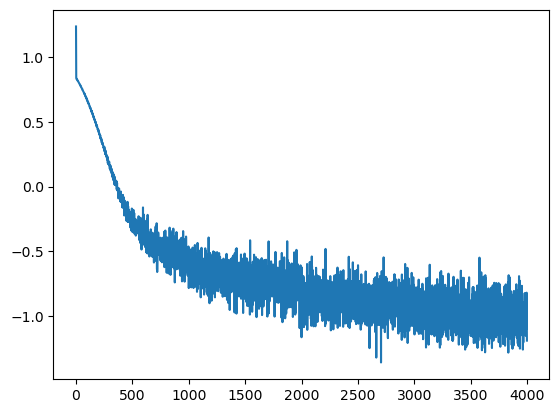

In [24]:
from matplotlib import pyplot as plt
import numpy as np
plt.plot(np.log(1.5+torch.tensor(train_loss)))

In [25]:
test_dataset = TensorDataset(X_test, test_indices)
test_loader = DataLoader(test_dataset, batch_size=256)

# Set into eval mode
model.eval()
likelihood.eval()
yhat = []
yvar = []
print("Predicting at test inputs")
with torch.no_grad(), gpytorch.settings.cholesky_max_tries(12):
    minibatch_iter = tqdm(test_loader,desc="Minibatch", leave=False)
    for x_batch, task_batch in minibatch_iter:
        predictions = likelihood(model(x_batch, task_indices=task_batch))
        mean = predictions.mean
        var = predictions.variance
        yhat.append(mean)
        yvar.append(var)
        

yhat_vector = torch.cat(yhat, 0)
yvar_vector = torch.cat(yvar,0)

Predicting at test inputs


Minibatch:   0%|          | 0/2 [00:00<?, ?it/s]

In [27]:
print("our error: ",(y_test - yhat_vector).square().mean().sqrt())
print("baseline error: ",(y_test-torch.tensor(test["p0Mean"].values)).square().mean().sqrt())

our error:  tensor(0.0671)
baseline error:  tensor(0.0665, dtype=torch.float64)


In [38]:
start = 200
end = start + 100

fhat = yhat_vector[start:end].reshape(10,10)
var = yvar_vector[start:end].reshape(10,10)
f = torch.tensor(test.iloc[start:end,7].values).reshape(10,10)
p0 = torch.tensor(test.iloc[start:end,9].values).reshape(10,10)
print("our error: ",(fhat-f).square().mean().sqrt())
print("baseline error: ",(p0-f).square().mean().sqrt())

our error:  tensor(0.0368, dtype=torch.float64)
baseline error:  tensor(0.0553, dtype=torch.float64)


Text(0.5, 1.0, 'Our Prediction')

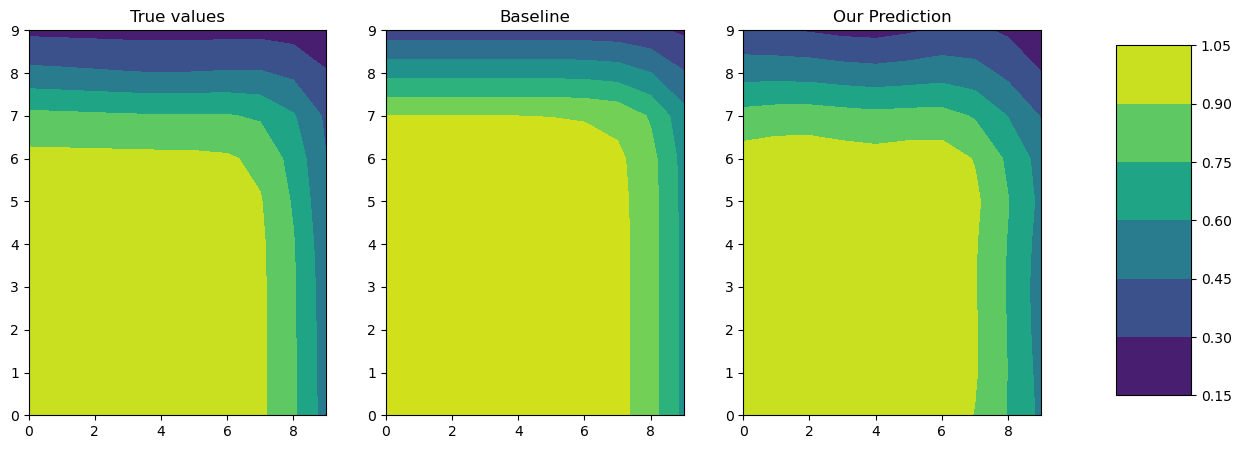

In [42]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(15, 5))
im = axes[0].contourf(f)
axes[1].contourf(p0)
axes[2].contourf(fhat)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im,cax=cbar_ax)
axes[0].set_title("True values")
axes[1].set_title("Baseline")
axes[2].set_title("Our Prediction")

Text(0.5, 1.0, 'Predictive variance')

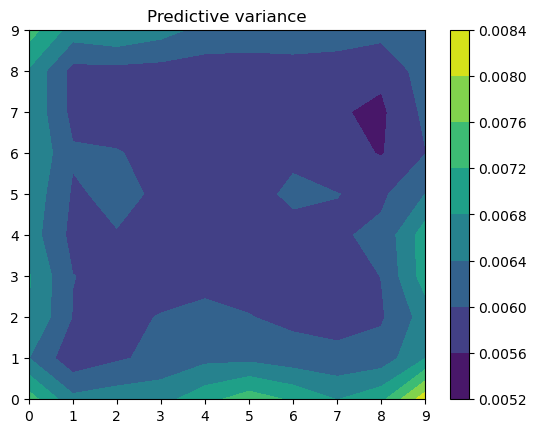

In [44]:
plt.contourf(var)
plt.colorbar()
plt.title("Predictive variance")